Title: The exploration of the "User knowledge" database

In [7]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(dplyr)

Introduction:

User modeling involves creating an imitation of the conceptual understanding of a user, which can be utilized to improve the customization and system interfaces to fit a user’s needs. This serves as a cheaper and more efficient alternative to user testing. In this particular user model, a dataset is used to predict the exam scores of users. This dataset includes five attributes, STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal objects). We hypothesized that there is a relationship between degree of study time, repetition, exam performances and UNS (the knowledge level of the user). We will use data analysis to check if our hypothesis is correct by using STG, SCG, and PEG to predict UNS. 
The dataset we will use: “User Knowledge” Dataset.
Training_data: 259 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high). 
Testing_data: 146 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high).


Preliminary Exploratory data analysis:


User modeling involves creating an imitation of the conceptual understanding of a user, which can be utilized to improve the customization and system interfaces to fit a user’s needs. This serves as a cheaper and more efficient alternative to user testing. In this particular user model, a dataset is used to predict the exam scores of users. This dataset includes five attributes, STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal objects). We hypothesized that there is a relationship between degree of study time, repetition, exam performances and UNS (the knowledge level of the user). We will use data analysis to check if our hypothesis is correct by using STG, SCG, and PEG to predict UNS. 

The dataset we will use: “User Knowledge” Dataset

Training_data: 259 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high). 

Testing_data: 146 rows of data with the first row being the title, the five attributes (STG, SCG, STR, LPR, PEG) each contains a value between 0 and 1, the target value UNS has four classifications (very low, low, middle, high). 


In [13]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "dataset.xls")

training_original <- read_excel("dataset.xls", sheet = 2)
testing_original <- read_excel("dataset.xls", sheet = 3)

tidy_testing_original <- select(testing_original, STG:UNS)
tidy_training_original <- select(training_original, STG:UNS)
new_user_data <- bind_rows(tidy_testing_original, tidy_training_original)

user_split <- initial_split(new_user_data, prop=0.75, stata = UNS)
training <- training(user_split)
testing <- testing(user_split)
head(training)
head(testing)




New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.380,0.59,0.31,0.62,0.20,Low
0.220,0.22,0.90,0.30,0.90,High
0.295,0.25,0.26,0.12,0.67,Middle
0.850,0.05,0.91,0.80,0.68,High
0.495,0.82,0.67,0.01,0.93,High
0.110,0.29,0.20,0.05,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.08,0.18,0.63,0.60,0.85,High
0.12,0.12,0.75,0.68,0.15,Low
0.23,0.29,0.45,0.18,0.88,High
0.10,0.30,0.58,0.28,0.55,Middle
0.12,0.28,0.70,0.16,0.32,Low


Methods:
Our group will use STG, SCG, PEG, and UNS to do the data analysis. We plan to use K-nearest neighbors classification to visualize the results. STC, SCG, and PEG will be used as predictors to predict UNS.

Cross-validation 

In [14]:
user_knowledge_recipe <- recipe(UNS ~ STG + SCG + PEG, data = training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

user_knowledge_recipe
user_knowledge_vfold <- vfold_cv(training, v = 5, strata = UNS)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |> 
    set_mode("classification")
user_knowledge_resample_fit <- workflow() |>
    add_recipe(user_knowledge_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = user_knowledge_vfold)
user_knowledge_metrics <- collect_metrics(user_knowledge_resample_fit)
user_knowledge_metrics


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.7154839,5,0.01646549,Preprocessor1_Model1
roc_auc,hand_till,0.8579124,5,0.01670144,Preprocessor1_Model1


Parameter value choose

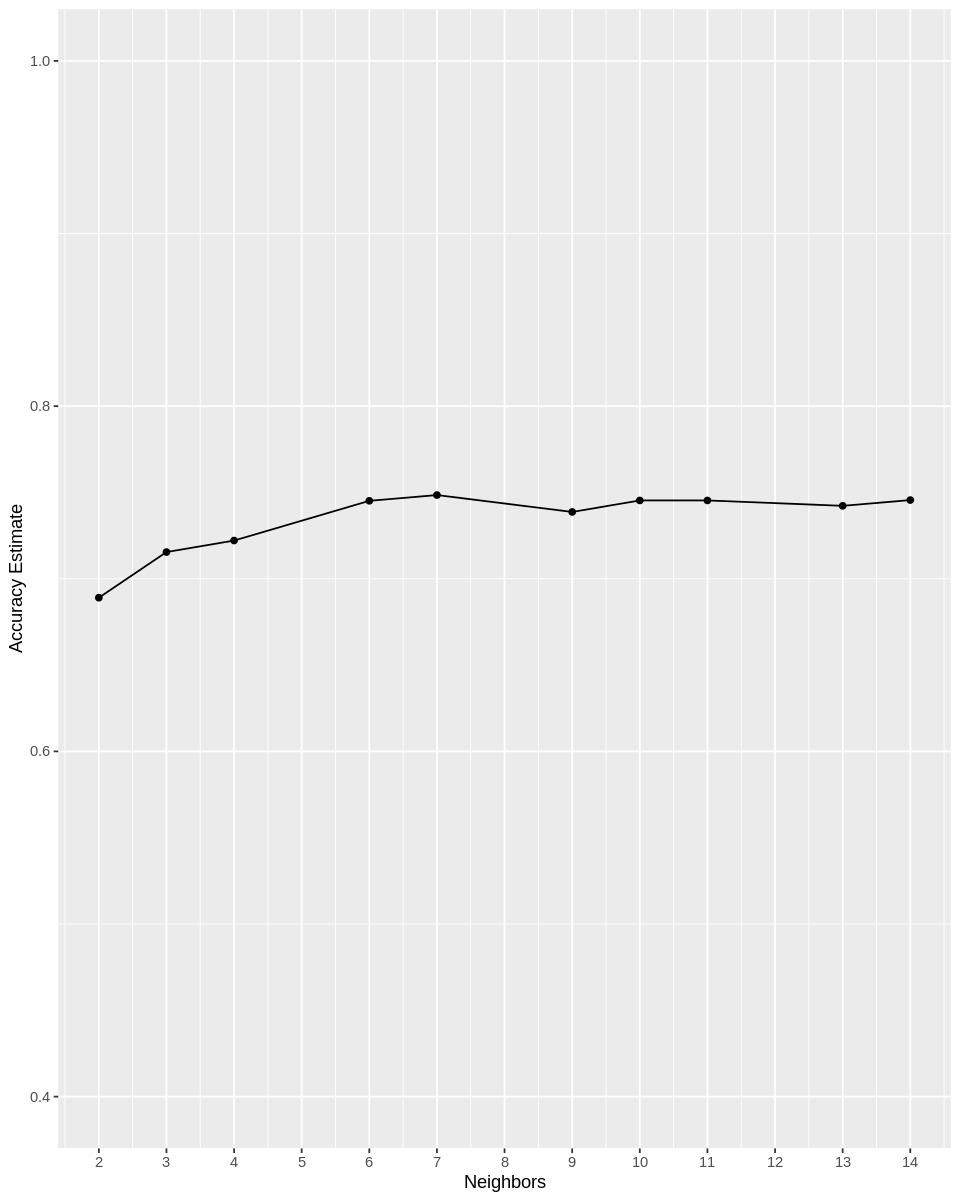

In [16]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
set_engine("kknn")%>%
set_mode("classification")

knn_results <- workflow() |>
add_recipe(user_knowledge_recipe) |>
add_model(knn_tune) |>
tune_grid(resamples = user_knowledge_vfold , grid = 10) |>
collect_metrics()

accuracies <- knn_results |> 
filter(.metric=="accuracy")
options(repr.plot.height = 10, repr.plot.width = 8)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

Expected outcomes and significance: We expect to use STC, SCG, and PEG as predictors to predict the knowledge level of this user. When we can predict the knowledge level of a user, we can match the suitable learning objects and methods to the needs of the users/students to help them learn more effectively. This finding can allow for personalized education, allowing users to improve their academic performance and achieve their potential. This is much more efficient than one-size-fits-all systems. Future questions this project could lead to include predicting different study methods and strategies tailored to a user’s mannerisms.
 


In [30]:

names <- colnames(training |> select(-UNS))
names

[1] "STG" "SCG" "STR" "LPR" "PEG"

In [37]:

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
user_vfold <- vfold_cv(training, v = 5, strata = UNS)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                                data = training) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(user_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = user_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

ERROR: Error in names[[j]]: subscript out of bounds
